# Titanic 생존자 분류 실습

# 목차
1. 데이터 불러오기
1. 데이터 관찰
1. 데이터 전처리
   1. 1309명 X 12차원(11 features, 1 label)
       1. Age: 나이
       1. Cabin: 객실 번호
       1. Embarked: 탑승 항구
       1. Fare: 탑승료
       1. Name: 이름
       1. Parch: 함께 탑승한 부모, 아이의 수
       1. PassengerId: 말 그대로 승객 ID
       1. Pclass: 좌석 등급
       1. Sex: 성별
       1. SibSp: 함께 탑승한 형제 자매 또는 배우자의 수
       1. Ticket: 티켓 번호    
       1. Survived : 생존(1) 사망(0)
1. 최종 데이터
   1. 1309명 X 19차원(18 features, 1 label)
1. 머신러닝 모델 학습
1. 학습 결과 분석
1. 최고 성능 모델로 재학습
1. 결과 저장

# 1. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
train_data = pd.read_csv('../input/titanic/train.csv')
test_data = pd.read_csv('../input/titanic/test.csv')
data = pd.concat([train_data,test_data],axis=0,ignore_index=True)
print('train shape ', train_data.shape, '; test shape ',test_data.shape, '; all data',data.shape)

train shape  (891, 12) ; test shape  (418, 11) ; all data (1309, 12)


# 2. 데이터 관찰하기

데이터는 

1309명(train: 891명, test shape: 418명)의 승객에 대해서 

12개 차원 (feature: 11개, label:1개)로 이루어져 있습니다.

### feature (11개)
1. Age: 나이
2. Cabin: 객실 번호
3. Embarked: 탑승 항구
4. Fare: 탑승료
5. Name: 이름
6. Parch: 함께 탑승한 부모, 아이의 수
7. PassengerId: 말 그대로 승객 ID
8. Pclass: 좌석 등급
9. Sex: 성별
10. SibSp: 함께 탑승한 형제 자매 또는 배우자의 수
11. Ticket: 티켓 번호

### label (1개)
12. Survived : 생존(1) 사망(0)

In [2]:
data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


숫자 데이터는 6개 (Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived)입니다.

In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


카테고리 데이터는 5개(Cabin,Embarked,Name,Sex,Ticket)입니다.

In [4]:
data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


# 3. 데이터 전처리

In [5]:
Survived = data.Survived

def join_survived_count(x,y,xName='x',yName='y'):
    tmp1 = pd.DataFrame({xName:x,yName:y})
    tmp1 = tmp1.groupby(yName).mean().sort_values(by=xName)
    tmp2 = y.value_counts().sort_values().to_frame()
    tmp2.columns = ['Count']
    tmp2.index.name = yName
    return(tmp1.join(tmp2))

## 3.1. Pclass: 좌석 등급
NA 값: 존재하지 않음.

값 범위: 1,2,3

1등급일수록 생존확률 증가

In [6]:
Pclass = data.Pclass
print(join_survived_count(Survived,Pclass,xName='Survived',yName='Pclass'))

        Survived  Count
Pclass                 
3       0.242363    709
2       0.472826    277
1       0.629630    323


## 3.2. Cabin: 객실 번호
NA 값: 1014개 존재 (N 값으로 대입)

Survived값에 따라서 7개의 그룹으로 분리함

In [7]:
Cabin = data.Cabin.fillna('N')
Cabin = Cabin.str.extract('(^\D)+', expand=False)
print(join_survived_count(Survived,Cabin,xName='Survived',yName='Cabin'))

Cabin = Cabin.map({'N':0,'T':0,'A':1,'G':1,'C':2,'F':3,'B':4,'E':5,'D':6})
print(join_survived_count(Survived,Cabin,xName='Survived',yName='Cabin'))

       Survived  Count
Cabin                 
T      0.000000      1
N      0.299854   1014
A      0.466667     22
G      0.500000      5
C      0.593220     94
F      0.615385     21
B      0.744681     65
E      0.750000     41
D      0.757576     46
       Survived  Count
Cabin                 
0      0.299419   1015
1      0.473684     27
2      0.593220     94
3      0.615385     21
4      0.744681     65
5      0.750000     41
6      0.757576     46


## 3.3. Embarked: 탑승 항구
NA 값: 2개 존재 (C값으로 대입)

One-hot 인코딩 수행함

In [8]:
Embarked = data.Embarked.fillna('N')
print(join_survived_count(Survived,Embarked,xName='Survived',yName='Embarked'))
Embarked = data.Embarked.fillna('C')
print(join_survived_count(Survived,Embarked,xName='Survived',yName='Embarked'))
Embarked_ctg = pd.get_dummies(Embarked,prefix='Embarked')

          Survived  Count
Embarked                 
S         0.336957    914
Q         0.389610    123
C         0.553571    270
N         1.000000      2
          Survived  Count
Embarked                 
S         0.336957    914
Q         0.389610    123
C         0.558824    272


## 3.4. Fare: 탑승료
NA 값: 1개 존재 (해당 승객의 class(좌석등급)이 3등급임으로 3등급 median 탑승료인 8.05부여)

In [9]:
Fare = data.Fare.copy(deep=True)

# NaN 값(1개 승객)을 Pclass(좌석등급)의 median 탑승료로 부여함
tmp = pd.DataFrame({'Pclass':Pclass,'Fare':Fare})
guess_Fare = tmp.groupby(['Pclass']).Fare.median()
for i in tmp.Pclass.unique():
    Fare.loc[(Fare.isnull()) & (tmp.Pclass == i)] = guess_Fare.loc[i]

# Fare의 그룹을 나눔
Fare.loc[ Fare <= 8] = 0
Fare.loc[(Fare > 8)  & (Fare <= 16),] = 1
Fare.loc[(Fare > 16) & (Fare <= 32),] = 2
Fare.loc[(Fare > 32) & (Fare <= 48),] = 3
Fare.loc[(Fare > 48) & (Fare <= 100)] = 4
Fare.loc[ Fare > 100] = 5
Fare -= Fare.min()
Fare /= Fare.max()
print(join_survived_count(Survived,Fare,xName='Survived',yName='Fare'))

      Survived  Count
Fare                 
0.0   0.215768    360
0.2   0.311475    357
0.6   0.319149     66
0.4   0.451282    281
0.8   0.648649    161
1.0   0.735849     84


## 3.5. Parch: 함께 탑승한 부모, 아이의 수

많은 가족이 있는 사람은 생존률이 낮다.

SibSp, Parch를 조합하여 Family Size를 계산한다.

In [10]:
FamilySize = pd.Series(data.SibSp + data.Parch, name='FamilySize')
print(join_survived_count(Survived,FamilySize,xName='Survived',yName='FamilySize'))
FamilySize = FamilySize.map({0:0,1:1,2:1,3:2,4:3,5:3,6:3,7:4,8:4,9:4,10:4})
print(join_survived_count(Survived,FamilySize,xName='Survived',yName='FamilySize'))

SibSp = pd.Series(data.SibSp, name='SibSp')
Parch = pd.Series(data.Parch, name='Parch')

            Survived  Count
FamilySize                 
7           0.000000      8
10          0.000000     11
5           0.136364     25
4           0.200000     22
0           0.303538    790
6           0.333333     16
1           0.552795    235
2           0.578431    159
3           0.724138     43
            Survived  Count
FamilySize                 
4           0.000000     19
3           0.204082     63
0           0.303538    790
1           0.562738    394
2           0.724138     43


## 3.6. Name: 이름

가족의 경우, 생존률이 연관되어 있다.

성(Surnames)에 대해서 가족이 생존한 여부를 조사한다.

In [11]:
Surname = data.Name.str.extract('(^\D+),', expand=False)
tmp = pd.DataFrame({'Surname':Surname,'name':data.Name})
N = 1309
hasFamilySurvived = pd.Series(np.zeros([N]),name='hasFamilySurvived')

for i in range(0,N):
    if (FamilySize.iloc[i]==0):
        continue
    thisname = Surname.iloc[i]
    index = Survived.loc[(tmp.Surname==thisname) & (Survived==1)].index
    if (i in index):
        index = index.drop(i)
    if (index.empty==False):
        hasFamilySurvived.iloc[i]=1

hasFamilySurvived=hasFamilySurvived.map({0.0:0,1.0:1})
print(join_survived_count(Survived,hasFamilySurvived,xName='Survived',yName='hasFamilySurvived'))

                   Survived  Count
hasFamilySurvived                 
0                  0.326057   1067
1                  0.651899    242


## 3.7 신분

5개의 신분을 구분함.

1. Capt, Col, Rev :    군인/목사 (생존률이 낮음)
2. Mr:               성인 남성(생존률 낮음)
3. Dr, Major, Master, Sir: 전문직?
4. Miss, Mlle, Lady: 젊은 여성
5. Mrs, Mme, Ms, Countess : 나이든 여성(생존률 높음)

In [12]:
Title = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
print(join_survived_count(Survived,Title,xName='Survived',yName='Title'))
Title.iloc[1305]
Title = Title.map({'Capt':0,'Col':0,'Rev':0,
           'Mr':1,                   
           'Dr':2,'Major':2,'Master':2,'Sir':2,
           'Miss':3,'Mlle':3,'Lady':3,'Dona':3,'Jonkheer':0,
           'Mrs':4,'Mme':4,'Ms':4,'Countess':4})
print(join_survived_count(Survived,Title,xName='Survived',yName='Title'))
Title_ctg = pd.get_dummies(Title,prefix='Title')

          Survived  Count
Title                    
Capt      0.000000      1
Don       0.000000      1
Jonkheer  0.000000      1
Rev       0.000000      8
Mr        0.156673    757
Dr        0.428571      8
Col       0.500000      4
Major     0.500000      2
Master    0.575000     61
Miss      0.697802    260
Mrs       0.792000    197
Mlle      1.000000      2
Mme       1.000000      1
Countess  1.000000      1
Ms        1.000000      2
Lady      1.000000      1
Sir       1.000000      1
Dona           NaN      1
       Survived  Count
Title                 
0.0    0.100000     14
1.0    0.156673    757
2.0    0.560000     72
3.0    0.702703    264
4.0    0.796875    201


## 3.8. PassengerId: 말 그대로 승객 ID

사용 안함

## 3.9. Sex: 성별

남자(male:1)는 여자(female:0)보다 생존률이 낮다.

In [13]:
Sex = data.Sex.map({'male':1,'female':0})
print(join_survived_count(Survived,Sex,xName='Survived',yName='Sex'))

     Survived  Count
Sex                 
1    0.188908    843
0    0.742038    466


## 3.10. SibSp: 함께 탑승한 형제 자매 또는 배우자의 수

혼자 여행하는 사람은 생존률이 낮다.

(Parch/SibSp을 이용해서 혼자 탑승한 여부를 계산)

In [14]:
isalone = pd.Series(((data.Parch + data.SibSp)==0).astype('int'),name='isalone')
print(join_survived_count(Survived,isalone,xName='Survived',yName='isalone'))

         Survived  Count
isalone                 
1        0.303538    790
0        0.505650    519


## 3.10. Ticket: 티켓 번호

생존률에 따라서 5개 그룹으로 나눔

In [15]:
Ticket = data.Ticket.str.extract('(\d+)$', expand=False)
Ticket.fillna(0,inplace=True)
Ticket = (Ticket.astype('int')/10000).astype('int')
tmp = pd.DataFrame({'Survived':Survived,'Ticket':Ticket})
tmp.groupby('Ticket').Survived.mean().sort_values()
print(join_survived_count(Survived,Ticket,xName='Survived',yName='Ticket'))
Ticket = Ticket.map({\
            4:0,5:0,21:0,32:0,26:0,34:0,
            31:1,38:1,35:1,37:1,310:1,36:1,
            0:2,6:2,2:2,39:2,23:2,
            25:3,24:3,11:3,33:3,3:3,
            1:4,22:4})
print(join_survived_count(Survived,Ticket,xName='Survived',yName='Ticket'))

        Survived  Count
Ticket                 
4       0.000000      7
5       0.000000      3
21      0.000000      4
32      0.000000      4
26      0.000000      1
34      0.140625    174
31      0.176471     27
38      0.200000     16
35      0.200000     34
37      0.240000     33
310     0.272727     60
36      0.303030     50
0       0.314607    266
6       0.333333      4
2       0.377778     70
39      0.416667     15
23      0.444444     51
25      0.500000     16
24      0.500000     39
11      0.513889    101
33      0.533333     27
3       0.558140     66
1       0.651007    227
22      0.750000     14
        Survived  Count
Ticket                 
0       0.127660    193
1       0.248322    220
2       0.346715    406
3       0.523529    249
4       0.656051    241


## 3.11. Age: 나이

나이가 적은 사람(어린이)는 성인에 비해 생존률이 높다.

나이를 모르는 경우(NA값)은 다른 데이터를 참조하여 유추함.

In [16]:
Age = data.Age.copy(deep=True)
Age.loc[(data.Age <= 8) & (data.Age.notna())] = 0
Age.loc[(data.Age > 8)  & (data.Age <= 16) & (data.Age.notna())] = 1
Age.loc[(data.Age > 16) & (data.Age <= 32) & (data.Age.notna())] = 2
Age.loc[(data.Age > 32) & (data.Age <= 48) & (data.Age.notna())] = 3
Age.loc[(data.Age > 48) & (data.Age <= 64) & (data.Age.notna())] = 4
Age.loc[(data.Age > 64) & (data.Age.notna())] = 5
print(join_survived_count(Survived,Age,xName='Survived',yName='Age'))

Age_X = pd.concat([Sex,Pclass,Fare,Title_ctg,Embarked_ctg,FamilySize,SibSp,Parch,isalone],axis=1)
Age_Y = Age.copy(deep=True)
Age_X_train = Age_X.loc[data.Age.notna()]
Age_Y_train = Age_Y.loc[data.Age.notna()]
Age_X_test = Age_X.loc[data.Age.isnull()]

from sklearn.svm import SVC, LinearSVC
AgeModel = SVC(C=5)
AgeModel.fit(Age_X_train, Age_Y_train)
print('Age training score ', round(AgeModel.score(Age_X_train, Age_Y_train) * 100, 2))
Age_Y_pred = AgeModel.predict(Age_X_test)
Age.loc[data.Age.isnull()] = Age_Y_pred

print(join_survived_count(Survived,Age,xName='Survived',yName='Age'))
Age -= Age.min()
Age /= Age.max()

     Survived  Count
Age                 
5.0  0.090909     13
2.0  0.369942    524
3.0  0.404255    269
1.0  0.413043     62
4.0  0.434783    106
0.0  0.666667     72
Age training score  64.91
     Survived  Count
Age                 
5.0  0.090909     13
2.0  0.343882    720
1.0  0.345455     73
3.0  0.410138    310
4.0  0.436620    109
0.0  0.619048     84


# 4. 최종 데이터

최종 데이터는 1309명 X 19 차원(Survived, Pclass, Age, Sex, Fare, Title_0, Title_1, Title_2, Title_3, Title_4, Embarked_C, Embarked_Q, Embarked_S, FamilySize, SibSp, Parch, hasFamilySurvived, Cabin, Ticket)으로 구성

In [17]:
data_pruned = pd.concat([Survived,Pclass,Age,Sex,Fare,Title_ctg,Embarked_ctg,
                         FamilySize,SibSp,Parch,hasFamilySurvived,Cabin,Ticket],axis=1)
data_pruned.head()

train = data_pruned.iloc[0:891]
test = data_pruned.iloc[891:1309]
train_X = train.loc[:,'Pclass':]
train_Y = train.loc[:,'Survived']
test_X = test.loc[:,'Pclass':]
test_Y = test.loc[:,'Survived']
print('shapes: ',train_X.shape,train_Y.shape,test_X.shape,test_Y.shape)

shapes:  (891, 18) (891,) (418, 18) (418,)


# 5. 머신러닝 모델 학습

14개 머신모델에 대해서 StratifiedKFold를 사용하여 10회 반복 학습

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

results=[]
i=0
random_state=1000
skf = StratifiedKFold(n_splits=10)
#skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
for train_idx, validation_idx in skf.split(train_X,train_Y):
    x_train = train_X.iloc[train_idx,:]
    y_train = train_Y.iloc[train_idx]
    x_validation = train_X.iloc[validation_idx,:]
    y_validation = train_Y.iloc[validation_idx]
    # 1. Logistic regression    
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(max_iter=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'LogisticRegression',accuracy_train,accuracy_validation,training_time])
    # 2. Decision tree
    from sklearn.tree import DecisionTreeClassifier
    model = DecisionTreeClassifier()
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'DecisionTree',accuracy_train,accuracy_validation,training_time])
    # 3. Support vector machine
    from sklearn.svm import SVC
    model = SVC()
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'SupportVectorMachine',accuracy_train,accuracy_validation,training_time])
    # 4. Gaussian naive bayes
    from sklearn.naive_bayes import GaussianNB
    model = GaussianNB()
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'GaussianNaiveBayes',accuracy_train,accuracy_validation,training_time])
    # 5. K nearest neighbor
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier()
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'KNearestNeighbor',accuracy_train,accuracy_validation,training_time]) 
    # 6. Random forest
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'RandomForest',accuracy_train,accuracy_validation,training_time])
    # 7. Gradient boosing
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(n_estimators=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'GradientBoosing',accuracy_train,accuracy_validation,training_time])
    # 8. Neural network
    from sklearn.neural_network import MLPClassifier
    model = MLPClassifier(max_iter=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'NeuralNetwork',accuracy_train,accuracy_validation,training_time])
    # 9. Bagging classifier
    from sklearn.ensemble import BaggingClassifier
    model = BaggingClassifier(n_estimators=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'BaggingClassifier',accuracy_train,accuracy_validation,training_time])
    # 10. Extra trees
    from sklearn.ensemble import ExtraTreesClassifier
    model = ExtraTreesClassifier(n_estimators=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'ExtraTrees',accuracy_train,accuracy_validation,training_time])    
    # 11. Adaboost
    from sklearn.ensemble import AdaBoostClassifier
    model = AdaBoostClassifier(n_estimators=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'AdaBoost',accuracy_train,accuracy_validation,training_time])    
    # 12. XGboost
    from xgboost import XGBClassifier
    model = XGBClassifier(n_estimators=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'XGBoost',accuracy_train,accuracy_validation,training_time])    
    # 13. LightGBM
    from lightgbm import LGBMClassifier
    model = LGBMClassifier(n_estimators=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'lightGBM',accuracy_train,accuracy_validation,training_time])    
    # 14. Catboost
    from catboost import CatBoostClassifier
    model = CatBoostClassifier(n_estimators=1000, verbose=False, random_state=random_state)
    start_time = time.time()
    model.fit(x_train, y_train)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    results.append([i,'CatBoostClassifier',accuracy_train,accuracy_validation,training_time])    
    i+=1

# 6. 학습 결과 분석

## 6.1. 결과 테이블 확인

In [19]:
df_results =pd.DataFrame(data=results, 
                columns= ['iter','method','accuracy_train','accuracy_validation','training_time'])
df_results.tail(20)

,iter,method,accuracy_train,accuracy_validation,training_time
120,8,BaggingClassifier,0.931421,0.865169,3.884473
121,8,ExtraTrees,0.931421,0.831461,2.081072
122,8,AdaBoost,0.836658,0.865169,2.415645
123,8,XGBoost,0.931421,0.831461,0.575037
124,8,lightGBM,0.931421,0.831461,0.591957
125,8,CatBoostClassifier,0.901496,0.876404,1.127719
126,9,LogisticRegression,0.841646,0.853933,0.037739
127,9,DecisionTree,0.940150,0.820225,0.004174
128,9,SupportVectorMachine,0.849127,0.853933,0.024009
129,9,GaussianNaiveBayes,0.801746,0.842697,0.004951


## 6.2. 결과 순위 확인

In [20]:
import numpy as np
df_acc_test = df_results.pivot_table(index='method', columns='iter')["accuracy_validation"].reset_index()
df_acc_test['mean']=np.mean(df_acc_test, axis=1)
df_acc_test=df_acc_test.sort_values('mean')
df_acc_test

iter,method,0,1,2,3,4,5,6,7,8,9,mean
5,GaussianNaiveBayes,0.777778,0.764045,0.775281,0.786517,0.797753,0.775281,0.808989,0.617978,0.876404,0.842697,0.782272
12,XGBoost,0.788889,0.820225,0.730337,0.842697,0.797753,0.786517,0.808989,0.853933,0.831461,0.808989,0.806979
3,DecisionTree,0.766667,0.842697,0.707865,0.853933,0.797753,0.808989,0.797753,0.831461,0.842697,0.820225,0.807004
13,lightGBM,0.833333,0.820225,0.730337,0.820225,0.820225,0.786517,0.797753,0.820225,0.831461,0.820225,0.808052
7,KNearestNeighbor,0.788889,0.775281,0.696629,0.820225,0.820225,0.842697,0.831461,0.831461,0.887640,0.820225,0.811473
6,GradientBoosing,0.800000,0.820225,0.752809,0.831461,0.831461,0.831461,0.820225,0.865169,0.831461,0.831461,0.821573
11,SupportVectorMachine,0.822222,0.786517,0.775281,0.842697,0.831461,0.808989,0.820225,0.820225,0.865169,0.853933,0.822672
0,AdaBoost,0.777778,0.820225,0.764045,0.865169,0.808989,0.820225,0.820225,0.842697,0.865169,0.853933,0.823845
9,NeuralNetwork,0.833333,0.775281,0.786517,0.853933,0.865169,0.786517,0.797753,0.842697,0.853933,0.876404,0.827154
10,RandomForest,0.833333,0.820225,0.719101,0.853933,0.853933,0.853933,0.831461,0.831461,0.853933,0.831461,0.828277


## 6.3. 결과 통계 측정

In [21]:
import numpy as np
from scipy import stats

# 비모수적 검정(parametric test)
print("Best model is {}. So, the others are compared to {}".format(
    df_acc_test.iloc[13,0],df_acc_test.iloc[13,0]))
for i in range(13):
    print(df_acc_test.iloc[i,0], 'vs.', df_acc_test.iloc[13,0],
          stats.wilcoxon(df_acc_test.iloc[i,1:-1], df_acc_test.iloc[13,1:-1])) # Wilcoxon signed-rank test

Best model is CatBoostClassifier. So, the others are compared to CatBoostClassifier
GaussianNaiveBayes vs. CatBoostClassifier WilcoxonResult(statistic=4.0, pvalue=0.028401837044201694)
XGBoost vs. CatBoostClassifier WilcoxonResult(statistic=0.0, pvalue=0.007473541540877042)
DecisionTree vs. CatBoostClassifier WilcoxonResult(statistic=1.0, pvalue=0.00683774356850919)
lightGBM vs. CatBoostClassifier WilcoxonResult(statistic=0.0, pvalue=0.007420961287866498)
KNearestNeighbor vs. CatBoostClassifier WilcoxonResult(statistic=4.0, pvalue=0.0162542088976566)
GradientBoosing vs. CatBoostClassifier WilcoxonResult(statistic=3.5, pvalue=0.041558707296959874)
SupportVectorMachine vs. CatBoostClassifier WilcoxonResult(statistic=9.0, pvalue=0.10880943004054568)
AdaBoost vs. CatBoostClassifier WilcoxonResult(statistic=11.0, pvalue=0.1689015887216404)
NeuralNetwork vs. CatBoostClassifier WilcoxonResult(statistic=14.5, pvalue=0.34069844083463674)
RandomForest vs. CatBoostClassifier WilcoxonResult(statis

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


## 6.4. 결과 시각화

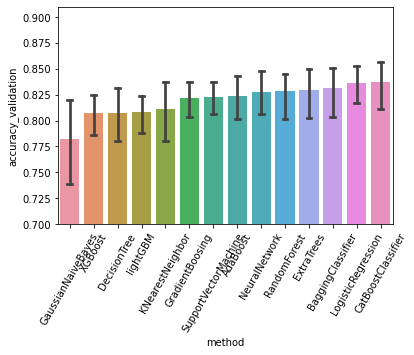

In [22]:
import seaborn as sns
#from statannot import add_stat_annotation
ax = sns.barplot(x="method", y="accuracy_validation", data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values('accuracy_validation').index)
ax.set(ylim=(0.70, 0.91))
ax.set_xticklabels(ax.get_xticklabels(),rotation=60);

## 7. 최고 성능 모델로 재학습

최고 성능 모델이 CatBoostClassifier이므로 전체 학습데이터셋(training+validation 데이터셋)을 사용하여 재학습

In [23]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(n_estimators=1000, verbose=False, random_state=random_state)
start_time = time.time()
model.fit(train_X, train_Y)
training_time = time.time() - start_time
y_pred_test = model.predict(test_X)

# 8. 결과 파일 저장

예측 결과를 Kaggle에 제출하는 형식으로 만든 후 csv 파일로 저장

In [24]:
submission = pd.DataFrame({
    "PassengerId": data[891:]["PassengerId"], 
    "Survived": y_pred_test
},dtype='int32')
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
